# Group: 27
### Submission: 01
### Devs:
    Vivek Verma: Q4, 5, 6, 7
    Harshil Sumra: Q8, 9
<hr>

#### Following are the paramters used for the compute question below:
|Symbol|Description|Value|
|-|-|-|
|T|Option Maturity|1.0|
|S_0|Current Stock Price|100.0|
|K|Strike Price - At-the-money|100.0|
|vol|Volatility|0.30|
|r|Risk-free rate|0.08|
|B_uo|Up-and-out Barrier|150.0|




In [1]:
T = 1.0
S_0 = 100.0
K = 100.0
vol = 0.30
r = 0.08
B_uo = 150.0

## 4. Price a European call option with the information provided

In [2]:
import numpy as np
from scipy.stats import uniform, norm
import matplotlib.pyplot as plt

In [3]:
def calc_d1(S0, K, r, vol, T):
    """Function to calculate d1"""
    return (np.log(S0 / K) + (r + .5 * vol ** 2) * T) / (vol * np.sqrt(T))


def calc_d2(d1, vol, T):
    """Function to calculate d2"""
    return d1 - vol * np.sqrt(T)


def calc_cdf(val):
    """Function to calculate cumulative distributive function using scipy norm pkg"""
    return norm.cdf(val)


def calc_price_analytical_eur_call_option(S0, r, T, vol, K, verbose=False):
    """Function to calculate price of Call option"""
    d1 = calc_d1(S0, K, r, vol, T)
    d2 = calc_d2(d1, vol, T)
    if verbose: print(f"d1: {d1}; d2: {d2}")
    price = S0 * calc_cdf(d1) - K * np.exp(-r * T) * calc_cdf(d2)  # compute price using all input and variables
    if verbose: print(f"Call option price: $ {price}, with a standard deviation of {vol} for time {T} and S0={S0} & K={K}")
    return price


def calc_terminal_shareprice(S_0, r, vol, Z, T):
    """Function to calculate the terminal share price using Z"""
    return S_0*np.exp((r - vol**2/2)*T + vol*np.sqrt(T)*Z)


def calc_discounted_call_payoff(S_T, K, r, T):
    """Function to calculate the Discounted Call Payoff"""
    return np.exp(-r*T)*np.maximum(S_T - K, 0)


def calc_price_numerical_eur_call_option(S_0, K, r, vol, T, cycles=50, iterations=1000):
    """Function to calculate the price of European Call Option using Monte Carlo Simulation"""
    np.random.seed(0)

    mcall_estimates = [None]*cycles
    mcall_std = [None]*cycles

    for i in range(1, cycles + 1):
        norm_array = norm.rvs(size=i * iterations)
        term_val = calc_terminal_shareprice(S_0, r, vol, norm_array, T)
        mcall_val = calc_discounted_call_payoff(term_val, K, r, T)
        mcall_estimates[i-1] = np.mean(mcall_val)
        mcall_std[i-1] = np.std(mcall_val)/np.sqrt(i * iterations)
    
    numerical_call_price = np.mean(mcall_estimates)
    print(f"The Numerical EUR CALL option computed via Monte-Carlo simulation is $ {numerical_call_price}")
    return numerical_call_price, mcall_estimates, mcall_std
    
    
def plot_estimated_and_analytical_values(analytical_value, cycles, estimated_values, estimated_values_std, 
                                        std_degree=3, analytical_plt_color='g', 
                                        estimated_plt_style='.', estimated_err_plt_color='r', 
                                        xlabel='Sample Size (x1000)', ylabel='Value'):
    """Function to plot the estimated values v/s the Analytical value"""
    plt.plot([analytical_value] * cycles, analytical_plt_color) # Plotting the actual value from Analytical approach.
    plt.plot(estimated_values, estimated_plt_style) # Plot the values estimated via Monte-Carlo Estimation
    plt.plot(analytical_value + np.array(estimated_values_std) * std_degree, estimated_err_plt_color) # <std-degree> standard deviations around the Mean in error bound
    plt.plot(analytical_value - np.array(estimated_values_std) * std_degree, estimated_err_plt_color) # <std-degree> standard deviations around the Mean in error bound
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

In [4]:
analytic_call_price = calc_price_analytical_eur_call_option(S_0, r, T, vol, K, verbose=True)

d1: 0.4166666666666667; d2: 0.1166666666666667
Call option price: $ 15.711312547892973, with a standard deviation of 0.3 for time 1.0 and S0=100.0 & K=100.0


In [5]:
cycles = 50
numerical_call_price, mcall_estimates, mcall_std = calc_price_numerical_eur_call_option(S_0, K, r, vol, T, cycles=cycles)

The Numerical EUR CALL option computed via Monte-Carlo simulation is $ 15.678885422394455


In [6]:
plot_estimated_and_analytical_values(analytic_call_price, cycles, mcall_estimates, mcall_std)

## 5. Price a European up-and-out barrier call option: Simulate paths for the underlying share and for the counterparty’s firm value using sample sizes of 1000, 2000, …, 50000. Do monthly simulations for the lifetime of the option

In [7]:
def calc_discounted_call_payoff(S_T, K, precomputed_exp_r_T):
    """
    Function for evaluating the discounted payoff of a call option
    :param S_T: terminal stk price
    :param K: Strike price
    :param precomputed_exp_r_T: equivalent of the np.exp(-rT)
    :return: Discounted payoff of a call option
    """
    return np.maximum(S_T - K, 0) * precomputed_exp_r_T


def calc_terminal_stock_price(precomputed_part_one, precomputed_part_two, Z):
    """
    Calculates the terminal stock price, given the pre-computed values and the random value of Z. Note this is using the same formula as defined in the previous calc_terminal_stock_price, but has 
    been reinforced to utilize the precomputed values, to speed up compute.
    :param precomputed_part_one: equivalent of the S_0*e^{(r - .5 * vol^2) * dt_i}, i being the index variable
    :param precomputed_part_two: equivalent of the e^{sqrt{dt_i} * vol}, i being the index variable
    :param Z: Random value to use for stk terminal price compute
    :return: Terminal stk price
    """
    return precomputed_part_one * precomputed_part_two ** Z


def calc_price_barrier_call_up_and_out(S_0, K, T, r, vol, B, cycles=1, base_iteration_steps=1000):
    """
    Function to compute the price for a Barrier Up And Out Call Option
    :param S_0: stk starting price
    :param K: Option Strike Price
    :param T: Option Life
    :param r: risk-free rate of interest
    :param vol: Volatility of underlying stk
    :param B: Barrier level
    :param cycles: number of epochs type iteration to perform
    :param base_iteration_steps: base number of iterations to perform in a cycle
    :return:
        Price of a Barrier Up And Out Call Option,
        Cycle length list of mean of the call option prices computed,
        Cycle length list of std dev of the call option prices computed,
    """

    months = int(T) * 12  # total months
    mcall_estimates = [None] * cycles
    mcall_std = [None] * cycles
    dt_step_value = 1 / 12

    # Pre-computing to save CPU time
    dt = np.array([0.0] * months)  # to store the time steps
    dt_S0_exp_r_vol = np.array([0.0] * months)  # to store the S_0*e^{(r - .5 * vol^2) * dt_i}, i being the index variable
    dt_sqrt_vol = np.array([0.0] * months)  # to store the e^{sqrt{dt_i} * vol}, i being the index variable

    for i in range(0, months):  # Compute the above declared arrays for all the months, which are the stepping function, because dt_i is gonna be same. Only Z would change.
        dt[i] = (i + 1) * dt_step_value
        dt_S0_exp_r_vol[i] = S_0 * np.exp((r - .5 * vol ** 2) * dt[i])
        dt_sqrt_vol[i] = np.exp(np.sqrt(dt[i]) * vol)

    exp_r_t = np.exp(-r * T)  # Compute the e^{-rT} value to be used for the calc_discounted_call_payoff
    # Pre-Compute Complete

    for simulation_cycle in range(1, cycles + 1):  # Going through the cycles
        simulation_limit = base_iteration_steps * simulation_cycle  # Calculating the number of sample sizes to use in this cycle
        random_store = norm.rvs(size=[simulation_limit, months])  # Generating normal random variables for the entire sample size population. 2-d array.
        barrier_call_option_price = np.array([0.0] * simulation_limit)  # Initializing array to use for storing the calculated Barrier Call Option Price

        for iteration in range(0, simulation_limit):  # Iterate through the sample size
            S_T = 0.0
            barrier_breached = False
            for month in range(0, months):  # Iterate through the months
                Z = random_store[iteration][month]  # Obtain the random value to be used for this iteration x month.
                S_T = calc_terminal_stock_price(dt_S0_exp_r_vol[month], dt_sqrt_vol[month], Z)  # Here all the pre-computed values will help in speeding up the compute. For more details, look at the PDF.
                if S_T > B:  # If stk price crosses barrier, then the iteration is null & void as the option expires.
                    barrier_breached = True
                    break
            barrier_call_option_price[iteration] = calc_discounted_call_payoff(S_T, K, exp_r_t) if not barrier_breached else 0.0
            # Compute the discounted call payoff for the S_T only if the barrier was unbreached, and store result.

        mcall_estimates[simulation_cycle - 1] = np.mean(barrier_call_option_price)  # Allot the mean of computed option price at cycle level
        mcall_std[simulation_cycle - 1] = np.std(barrier_call_option_price) / np.sqrt(simulation_limit)  # Allot the std deviation of computed option price at cycle level
    return np.mean(mcall_estimates), mcall_estimates, mcall_std


def calc_price_barrier_call_up_and_out_alternate_approach(S_0, K, T, r, vol, B, cycles=1, base_iteration_steps=1000):
    """
    Alternate Function to compute the price for a Barrier Up And Out Call Option. The difference of this method and the calc_price_barrier_call_up_and_out is explained in the PDF.
    :param S_0: stk starting price
    :param K: Option Strike Price
    :param T: Option Life
    :param r: risk-free rate of interest
    :param vol: Volatility of underlying stk
    :param B: Barrier level
    :param cycles: number of epochs type iteration to perform
    :param base_iteration_steps: base number of iterations to perform in a cycle
    :return:
        Price of a Barrier Up And Out Call Option,
        Cycle length list of mean of the call option prices computed,
        Cycle length list of std dev of the call option prices computed,
    """
    months = int(T) * 12  # total months
    n_steps = 12  # Define number of steps.
    mcall_estimates = [None] * cycles
    mcall_std = [None] * cycles

    # Pre-computing below vals to save CPU time
    dt = T / n_steps
    dt_sqrt = np.sqrt(dt)
    vol_dt_sqrt = vol * dt_sqrt
    exp_vol_dt_sqrt = np.exp(vol_dt_sqrt)
    r_vol_dt = (r - 0.5 * vol ** 2) * dt
    exp_r_vol_dt = np.exp(r_vol_dt)
    exp_r_T = np.exp(-r * T)

    for simulation_cycle in range(1, cycles + 1):
        simulation_limit = base_iteration_steps * simulation_cycle
        random_store = norm.rvs(size=[simulation_limit, months])
        calls = np.array([0.0] * simulation_limit)

        for iteration in range(0, simulation_limit):
            S_T = S_0
            barrier_breached = False
            for month in range(0, months):
                Z = random_store[iteration][month]
                S_T *= exp_r_vol_dt * exp_vol_dt_sqrt ** Z
                if S_T > B:
                    barrier_breached = True
                    break
            calls[iteration] = calc_discounted_call_payoff(S_T, K, exp_r_T) if not barrier_breached else 0.0

        mcall_estimates[simulation_cycle - 1] = np.mean(calls)
        mcall_std[simulation_cycle - 1] = np.std(calls) / np.sqrt(simulation_limit)
    return np.mean(mcall_estimates), mcall_estimates, mcall_std
    

In [8]:
cycles = 50

from datetime import datetime
dt1 = datetime.now()
barrier_up_out_price, call_estimates, call_std = calc_price_barrier_call_up_and_out(S_0=S_0, K=K, T=T, r=r, vol=vol, B=B_uo, cycles=cycles)
print(f"Price for the Barrier up-and-out Call: $ {barrier_up_out_price:.3f}")
delta = datetime.now() - dt1
print(f"Time taken for the compute: {delta}")


Price for the Barrier up-and-out Call: $ 5.279
Time taken for the compute: 0:00:28.522509


#### Analytical Value compute part below

In [9]:
def calc_v(r, vol):
    return r - .5 * vol ** 2


def calc_d(a, b, v, vol, T):
    return (np.log(a / b) + v * T) / (vol * np.sqrt(T))


def calc_analytical_up_and_out_barrier(S0, r, T, vol, K, B):
    """Function to calculate the Analytical price of the Barrier Up and Out Option"""
    v = calc_v(r, vol)
    call_price_S_K = calc_price_analytical_eur_call_option(  # Computes C_BS (S, K)
        S0=S0,
        r=r,
        T=T,
        vol=vol,
        K=K
    )
    call_price_S_B = calc_price_analytical_eur_call_option(  # Computes C_BS (S, B)
        S0=S0,
        r=r,
        T=T,
        vol=vol,
        K=B
    )
    call_price_B2_S_K = calc_price_analytical_eur_call_option(  # Computes C_BS (B^2/S, K)
        S0=B ** 2 / S0,
        r=r,
        T=T,
        vol=vol,
        K=K
    )
    call_price_B2_S_B = calc_price_analytical_eur_call_option(  # Computes C_BS (B^2/S, B)
        S0=B ** 2 / S0,
        r=r,
        T=T,
        vol=vol,
        K=B
    )

    part_1 = call_price_S_K - call_price_S_B - (B - K) * np.exp(-r * T) * calc_cdf(calc_d(S0, B, v, vol, T))
    part_2 = (B / S0) ** (2 * v / (vol ** 2)) * (call_price_B2_S_K - call_price_B2_S_B - (B - K) * np.exp(-r * T) * calc_cdf(calc_d(B, S0, v, vol, T)))
    analytical_barrier_option_price = part_1 - part_2  # Brings together the parts shown in PDF, to compute the Analytical Barrier up-and-out price
    print(f"Barrier up and out at {B} price: {analytical_barrier_option_price} with a standard deviation of {vol} for time {T} and S0={S0} & K={K}")
    return analytical_barrier_option_price


In [10]:
analytic_barrier_up_out_price = calc_analytical_up_and_out_barrier(S_0, r, T, vol, K, B_uo)

Barrier up and out at 150.0 price: 5.312942876953661 with a standard deviation of 0.3 for time 1.0 and S0=100.0 & K=100.0


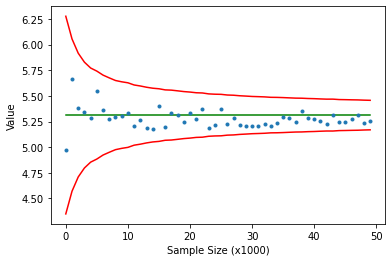

In [11]:
plot_estimated_and_analytical_values(
    analytical_value=analytic_barrier_up_out_price, 
    estimated_values=call_estimates, 
    estimated_values_std=call_std,
    cycles=cycles
)

In [12]:
from datetime import datetime
dt1 = datetime.now()
barrier_up_out_price_alternate, call_estimates_alternate, call_std_alternate = calc_price_barrier_call_up_and_out_alternate_approach(S_0=S_0, K=K, T=T, r=r, vol=vol, B=B_uo, cycles=cycles)
print(f"Price for the Barrier up-and-out Call using alternate approach: $ {barrier_up_out_price_alternate:.3f}")
delta = datetime.now() - dt1
print(f"Time taken for the compute: {delta}")


Price for the Barrier up-and-out Call using alternate approach: $ 6.698
Time taken for the compute: 0:00:26.140598


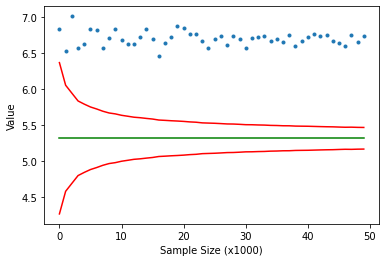

In [13]:
plot_estimated_and_analytical_values(
    analytical_value=analytic_barrier_up_out_price, 
    estimated_values=call_estimates_alternate, 
    estimated_values_std=call_std_alternate,
    cycles=cycles
)

## 6. Price a European up-and-in barrier call option.

In [14]:
analytical_barrier_up_in_price = analytic_call_price - analytic_barrier_up_out_price
print(f"The Analytical Barrier Up-and-In Price is: $ {analytical_barrier_up_in_price}")

The Analytical Barrier Up-and-In Price is: $ 10.398369670939312


In [15]:
barrier_up_in_price = numerical_call_price - barrier_up_out_price
print(f"The Barrier Up-and-In Price is: $ {barrier_up_in_price}")

The Barrier Up-and-In Price is: $ 10.399698852297902


## 7. Repeat Question 5 (Price up-and-out barrier call) 6 times, keeping all the data the same, but using a new strike level in each case: a) 85, b) 90, c) 95, d) 105, e) 110, f) 115. Produce a table of 7 rows that shows the strike, and the option price.

In [16]:
strikes = [85, 90, 95, 105, 110, 115]
T = 1.0
S_0 = 100.0
vol = 0.30
r = 0.08
B_uo = 150.0

In [17]:
dt1 = datetime.now()

cycles = 50
barrier_up_out_prices = [calc_price_barrier_call_up_and_out(S_0, K, T, r, vol, B_uo, cycles=cycles)[0] for K in strikes]
print(barrier_up_out_prices)

delta = datetime.now() - dt1
print(f"Time taken for the compute: {delta}")

[10.04865115839705, 8.259922961268577, 6.627448166392058, 4.067745916796634, 3.0588993332276475, 2.224450795848716]
Time taken for the compute: 0:02:58.425042


In [18]:
import pandas as pd

In [19]:
solution_df = pd.DataFrame(columns = ["Strike Price", "Barrier Up-and-Out Price"])
for i in range(0, len(strikes)):
    data = {
        "Strike Price": strikes[i], 
        "Barrier Up-and-Out Price": barrier_up_out_prices[i]
    }
    solution_df = solution_df.append(data, ignore_index=True)
solution_df

Strike Price  Barrier Up-and-Out Price
0          85.0                 10.048651
1          90.0                  8.259923
2          95.0                  6.627448
3         105.0                  4.067746
4         110.0                  3.058899
5         115.0                  2.224451

### Q.8 and Q.9

In [ ]:
#i/p variables

#Market-specific inputs
r_f = 0.08

#Stock-specific inputs
S_0 = 100 
sigma_stock = 0.3

#Option-specific inputs
T = 1
months = 12*T
K = 100 #Option struck at-the-money
B = 150

#Counterparty-specific inputs
sigma_cp = 0.25
debt = 175 #Due in one year, same as the option's maturity
corr_stock_cp = 0.2
recovery_rate = 0.25
V_0 = 200

In [ ]:
#import necessary packages and set seed value
import numpy as np
np.random.seed(0)

#o/p arrays
eu_uao_call_mean = [None]*50
eu_uao_call_stderror = [None]*50

cva_mean = [None]*50
cva_stderror = [None]*50

default_adj_call_val = [None]*50
default_adj_call_val_stderror = [None]*50

Function definations

In [ ]:
#Terminal stock price
def terminal_value(initial_stock_price, risk_free_rate, volatility, Z, time_to_maturity):
    return initial_stock_price * np.exp((risk_free_rate - volatility**2/2)*time_to_maturity + volatility*np.sqrt(time_to_maturity)*Z)
#discounted vanilla call payoff
def discounted_call_payoff(terminal_stock_price, strike, risk_free_rate, time_to_maturity):
    return np.exp(-risk_free_rate*time_to_maturity)*np.maximum(terminal_stock_price - strike, 0)

In [ ]:
#Stock price path generator based on geometric Brownian motion
def stock_price_path(periods_per_path, current_stock_price, risk_free_rate, stock_vol, time_increment):
    
    series = np.zeros(periods_per_path)
    series[0] = current_stock_price
    
    for i in range(1, periods_per_path):        
        dWt = np.random.normal(0, 1) * np.sqrt(time_increment) #Brownian motion
        series[i] = series[i-1] * np.exp((risk_free_rate - stock_vol**2/2)*time_increment + stock_vol*dWt)

    return series

In [ ]:
#Black scholes price of vanilla call option
def bs_call(current_stock_price, strike, time_to_maturity, risk_free_rate, volatility):
    
    from scipy import stats
    
    d1 = (np.log(current_stock_price/strike) + (risk_free_rate + volatility**2/2)*time_to_maturity)/(volatility*np.sqrt(time_to_maturity))
    d2 = d1 - volatility * np.sqrt(time_to_maturity)
    
    return current_stock_price * stats.norm.cdf(d1) - strike * np.exp(-risk_free_rate*time_to_maturity) * stats.norm.cdf(d2)

In [ ]:
#Vanilla call payoff
def call_payoff(terminal_stock_price, strike):
    return np.maximum(terminal_stock_price - strike, 0)

Correlation matrix

In [ ]:
corr = np.array([[1, corr_stock_cp],[corr_stock_cp, 1]])

Monte Carlo Simulations

In [ ]:
from scipy.stats import norm

In [ ]:
for simulation in range(1, 51):

    paths = simulation*1000
    all_paths = np.zeros([paths, months])
    
    #Call price estimate
    for i in range(0, paths):
        all_paths[i] = stock_price_path(months, S_0, r_f, sigma_stock, T/months)
        
    call_values = np.zeros([paths, 2])
    path_no = -1

    for path in all_paths:
        path_no += 1
        
        if sum((path >= B)) == 0:
            
            call_values[path_no, 0] = discounted_call_payoff(path[len(path)-1], K, r_f, T)
            call_values[path_no, 1] = 1
        
    eu_uao_call_mean[simulation-1] =  np.mean(np.extract(call_values[:, 1] == 1, call_values[:, 0]))
    eu_uao_call_stderror[simulation-1] = np.std(np.extract(call_values[:, 1] == 1, call_values[:, 0])
                                                     ) / np.sqrt(np.sum(call_values[:, 1]))

    #CVA estimate
    norm_matrix = norm.rvs(size = np.array([2, paths]))
    corr_norm_matrix = np.matmul(np.linalg.cholesky(corr), norm_matrix)

    terminal_stock_val = terminal_value(S_0, r_f, sigma_stock, corr_norm_matrix[0, ], T)
    terminal_firm_val = terminal_value(V_0, r_f, sigma_cp, corr_norm_matrix[1, ], T)
    call_terminal_val = call_payoff(terminal_stock_val, K)
    
    amount_lost = np.exp(-r_f*T) * (1-recovery_rate) * (terminal_firm_val < debt) * call_terminal_val
    
    cva_mean[simulation-1] = np.mean(amount_lost)
    cva_stderror[simulation-1] = np.std(amount_lost)/ np.sqrt(paths) 

    #Default-adjusted Call Value
    default_adj_call_val[simulation-1] = eu_uao_call_mean[simulation-1] - cva_mean[simulation-1]
    default_adj_call_val_stderror[simulation-1] = np.sqrt((eu_uao_call_stderror[simulation-1])**2 + 
                                                          (cva_stderror[simulation-1])**2)
    
    print('Running simulation', simulation, '=>\n', 'Call Value:', eu_uao_call_mean[simulation-1].round(3),'\n', 
          'CVA:', cva_mean[simulation-1].round(3),'\n', 'Default-adj Call Value:', 
          default_adj_call_val[simulation-1].round(3))

Running simulation 1 =>
 Call Value: 8.101 
 CVA: 1.654 
 Default-adj Call Value: 6.447
Running simulation 2 =>
 Call Value: 7.502 
 CVA: 1.956 
 Default-adj Call Value: 5.546
Running simulation 3 =>
 Call Value: 8.177 
 CVA: 1.963 
 Default-adj Call Value: 6.215
Running simulation 4 =>
 Call Value: 8.103 
 CVA: 1.873 
 Default-adj Call Value: 6.23
Running simulation 5 =>
 Call Value: 8.4 
 CVA: 2.094 
 Default-adj Call Value: 6.306
Running simulation 6 =>
 Call Value: 7.837 
 CVA: 1.854 
 Default-adj Call Value: 5.983
Running simulation 7 =>
 Call Value: 8.108 
 CVA: 1.793 
 Default-adj Call Value: 6.315
Running simulation 8 =>
 Call Value: 8.21 
 CVA: 1.774 
 Default-adj Call Value: 6.436
Running simulation 9 =>
 Call Value: 8.19 
 CVA: 1.975 
 Default-adj Call Value: 6.215
Running simulation 10 =>
 Call Value: 8.181 
 CVA: 1.951 
 Default-adj Call Value: 6.231
Running simulation 11 =>
 Call Value: 8.077 
 CVA: 1.817 
 Default-adj Call Value: 6.26
Running simulation 12 =>
 Call Value

In [ ]:
import pandas as pd
df = pd.DataFrame(list(zip(eu_uao_call_mean, cva_mean, default_adj_call_val)), columns = ['Default-free UAO Call Value', 'CVA Estimate', 'Default-adjusted UAO Call Value'])
df.index.name = 'Simulation No.'
df.index += 1
print(df.info())
df.round(3).head()
  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 1 to 50
Data columns (total 3 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Default-free UAO Call Value      50 non-null     float64
 1   CVA Estimate                     50 non-null     float64
 2   Default-adjusted UAO Call Value  50 non-null     float64
dtypes: float64(3)
memory usage: 1.3 KB
None


Default-free UAO Call Value  CVA Estimate  \
Simulation No.                                              
1                                     8.101         1.654   
2                                     7.502         1.956   
3                                     8.177         1.963   
4                                     8.103         1.873   
5                                     8.400         2.094   

                Default-adjusted UAO Call Value  
Simulation No.                                   
1                                         6.447  
2                                         5.546  
3                                         6.215  
4                                         6.230  
5                                         6.306

Plotting

In [ ]:
#import required library
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#Default free uao eu call option
plt.plot([sum(eu_uao_call_mean)/len(eu_uao_call_mean)]*50)
plt.plot(eu_uao_call_mean, '.')
plt.plot(sum(eu_uao_call_mean)/len(eu_uao_call_mean) + 
         np.array(eu_uao_call_stderror) * 3, 'r')
plt.plot(sum(eu_uao_call_mean)/len(eu_uao_call_mean) - 
         np.array(eu_uao_call_stderror) * 3, 'r');


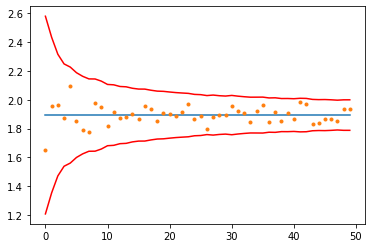

In [ ]:
#CVA estimates
plt.plot([sum(cva_mean)/len(cva_mean)]*50)
plt.plot(cva_mean, '.')
plt.plot(sum(cva_mean)/len(cva_mean) + np.array(cva_stderror) * 3, 'r')
plt.plot(sum(cva_mean)/len(cva_mean) - np.array(cva_stderror) * 3, 'r');

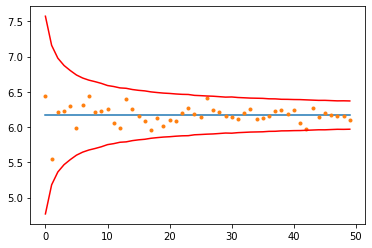

In [ ]:
#default adj european call option
plt.plot([sum(default_adj_call_val)/len(default_adj_call_val)]*50)
plt.plot(default_adj_call_val, '.')
plt.plot(sum(default_adj_call_val)/len(default_adj_call_val) + np.array(default_adj_call_val_stderror) * 3, 'r')
plt.plot(sum(default_adj_call_val)/len(default_adj_call_val) - np.array(default_adj_call_val_stderror) * 3, 'r');